# Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Data loading

In [3]:
# List of transformations to apply to the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

# Diwnload the MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
dataiter = iter(data_loader)
images, labels = next(dataiter)


tensor(0.) tensor(1.)


In [27]:
# In the MNIST dataset the values if the tensors are between 0 and 1 so we need a sigmoid activation function
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [9]:
def plot_tensor(tensor):
    plt.figure()
    plt.imshow(tensor.numpy().squeeze(), cmap='gray_r')
    plt.show()

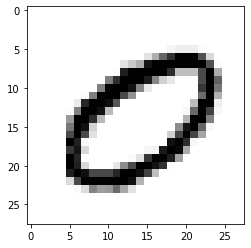

In [18]:
sample = images[1]
plot_tensor(sample)

# Architecture of the first autoencoder: Linear

In [30]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()   
        # The encoder compresses the input of size 784 into a latent space of size 3     
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        # The decoder expands the latent space back to the original input size
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [31]:
model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [32]:
len(data_loader)

938

In [33]:
def train(model, data_loader, num_epochs):
    outputs = []
    for epoch in range(num_epochs):
        for data in data_loader:
            img, _ = data
            img = img.view(img.size(0), -1)
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon))
    return outputs

In [46]:
num_epochs = 10
outputs = train(model, data_loader, num_epochs=num_epochs)

Epoch:1, Loss:0.0296
Epoch:2, Loss:0.0304
Epoch:3, Loss:0.0335
Epoch:4, Loss:0.0284
Epoch:5, Loss:0.0368
Epoch:6, Loss:0.0350
Epoch:7, Loss:0.0309
Epoch:8, Loss:0.0337
Epoch:9, Loss:0.0401
Epoch:10, Loss:0.0339


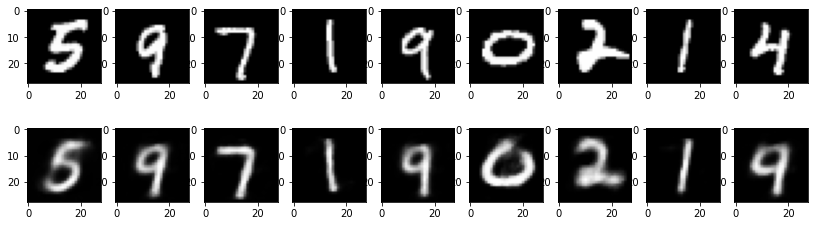

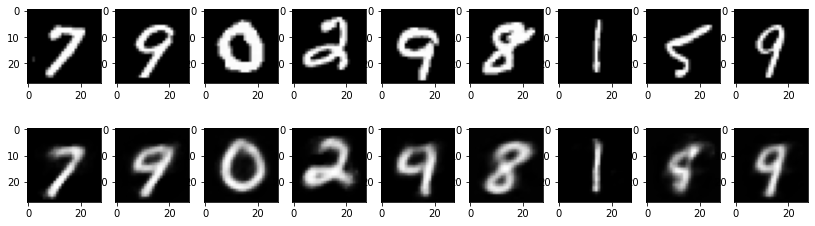

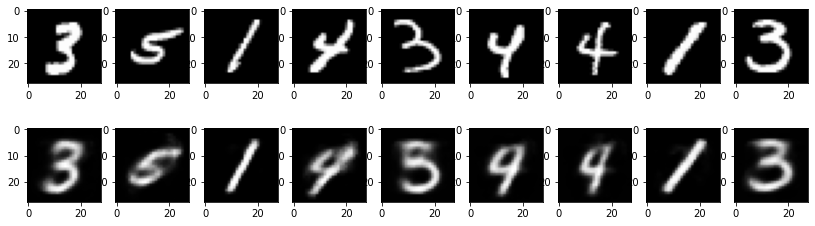

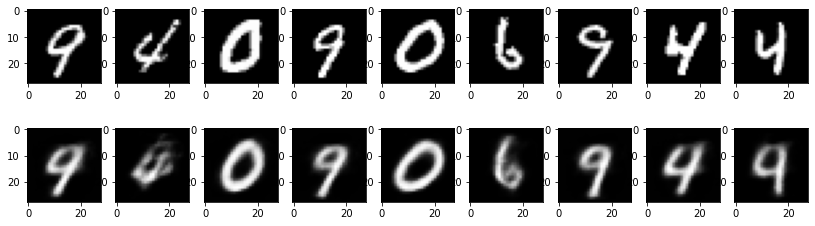

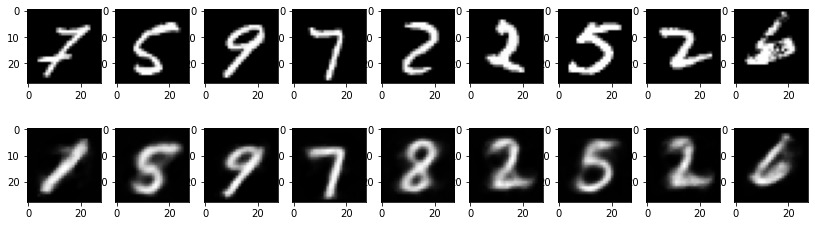

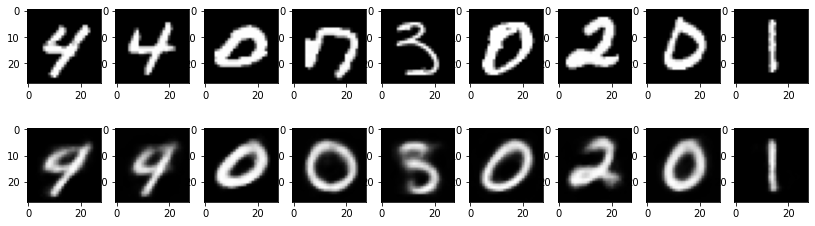

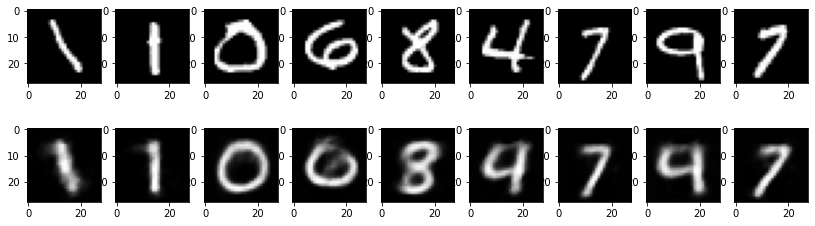

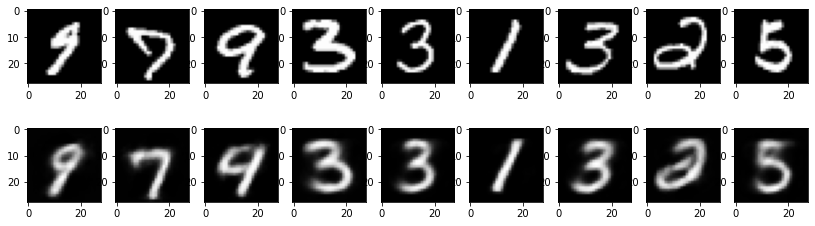

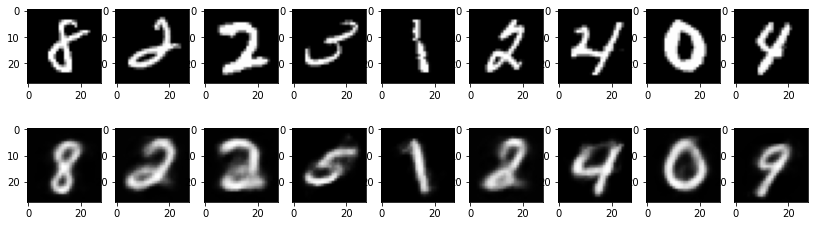

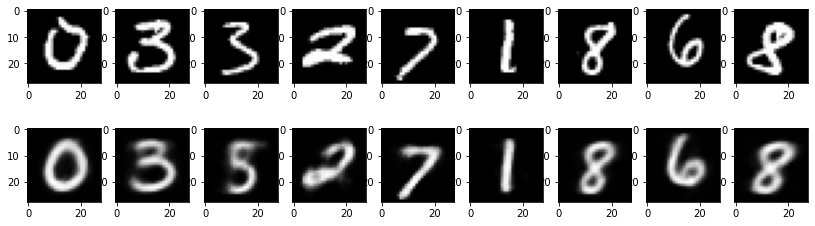

In [74]:
for k in range(0, num_epochs):
    plt.figure(figsize=(14, 4))
    plt.title('Epoch:{}'.format(k))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item.reshape(28, 28))
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        plt.imshow(item.reshape(28, 28))

# Architecture of the second autoencoder: Convolutions

In [75]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 


In [81]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [82]:
def train(model, data_loader, num_epochs):
    outputs = []
    for epoch in range(num_epochs):
        for data in data_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon))
    return outputs

In [83]:
num_epochs = 2
outputs = train(model, data_loader, num_epochs=num_epochs)

Epoch:1, Loss:0.0083
Epoch:2, Loss:0.0058


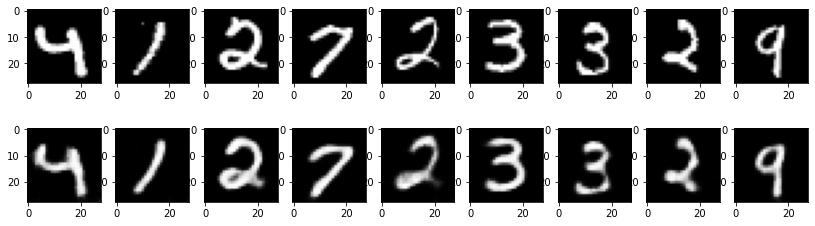

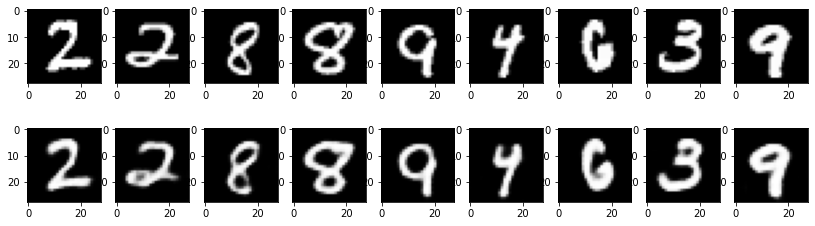

In [84]:
for k in range(0, num_epochs):
    plt.figure(figsize=(14, 4))
    plt.title('Epoch:{}'.format(k))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item.reshape(28, 28))
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        plt.imshow(item.reshape(28, 28))